# Road segmentation pix2pix

## Setup

In [2]:
import os
from glob import glob

import sys
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

from tqdm import tqdm

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa

from termcolor import colored



import warnings
warnings.filterwarnings(action='ignore')

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# 데이터 확인하기
## 데이터 위치에서 데이털 이름 확인
data_path = '../data/ex16/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))
print(os.listdir(data_path)[:10])

number of train examples : 1002
['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '101.jpg', '102.jpg', '103.jpg', '104.jpg', '105.jpg', '106.jpg']


image shape :  (256, 512, 3)


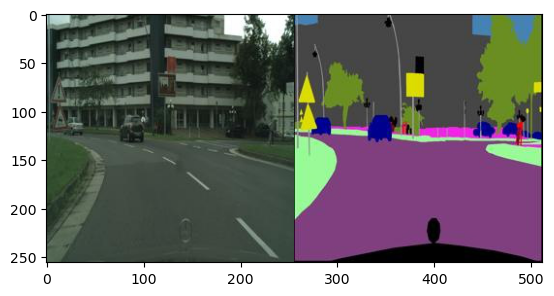

In [4]:
## 데이터 샘플 뽑기, 이미지 사이즈 확인하기
sample_path = data_path + os.listdir(data_path)[0]
sample = plt.imread(sample_path)
print(colored("image shape : ","red"),sample.shape)
plt.imshow(sample)
plt.show()

In [5]:
# 데이터 분할 하여 저장하기 (미리 해서 저장을 해두는 것이 메모리 면에서 유리할 것으로 보임)

## 이미지를 분할하여 train/image, train/annotation 폴더에 각각 저장
### 각 폴더를 만듦

data_path = '../data/ex16/cityscapes/train/'
try:
    os.mkdir("../data/ex16/cityscapes/train/images")
    os.mkdir("../data/ex16/cityscapes/train/annotations")
except:
    pass

### 이미지 반갈죽 함수 생성
def image_sep_save(image_path):
    """
    input : image_path (origin_image, shape :[256,512,3])
    output : image (shape : [256,256,3]), annotation (shape : [256,256,3])
    """
    sample = plt.imread(data_path+image_path)
    image = sample[:,:256,:]
    annotation = sample[:,256:,:]
    
    plt.imsave(data_path+"images/image_"+image_path,image)
    plt.imsave(data_path+"annotations/annotation_"+image_path,annotation)
    
### 실행
for image_path in tqdm(os.listdir(data_path)):
    try:
        if image_path.endswith('jpg'):  
            image_sep_save(image_path)
    except:
        print("something wrong")

100%|██████████| 1002/1002 [00:11<00:00, 89.02it/s]


In [6]:
# 데이터 분할 하여 저장하기 (미리 해서 저장을 해두는 것이 메모리 면에서 유리할 것으로 보임)

## 이미지를 분할하여 train/image, train/annotation 폴더에 각각 저장
### 각 폴더를 만듦

data_path = '../data/ex16/cityscapes/val/'
try:
    os.mkdir("../data/ex16/cityscapes/val/images")
    os.mkdir("../data/ex16/cityscapes/val/annotations")
except:
    pass

### 이미지 반갈죽 함수 생성
def image_sep_save(image_path):
    """
    input : image_path (origin_image, shape :[256,512,3])
    output : image (shape : [256,256,3]), annotation (shape : [256,256,3])
    """
    sample = plt.imread(data_path+image_path)
    image = sample[:,:256,:]
    annotation = sample[:,256:,:]
    
    plt.imsave(data_path+"images/image_"+image_path,image)
    plt.imsave(data_path+"annotations/annotation_"+image_path,annotation)
    
### 실행
for image_path in tqdm(os.listdir(data_path)):
    try:
        if image_path.endswith('jpg'):  
            image_sep_save(image_path)
    except:
        print("something wrong")

100%|██████████| 7/7 [00:00<00:00, 123.11it/s]


In [7]:
# 데이터 셋 만들기
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

## path2image 함수
def path2image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    return normalize(img)

## Aungmentation 함수 생성
### 랜덤하게 90,180,270회전, 대칭이동, 노이즈, 확대&회전 함수 생성
        
### 회전 랜덤
def do_random_rot90(image, label):
    r = np.random.choice([0,1,2,3])
    if r==0:
        return image, label
    else:
        image = tf.image.rot90(image, k=r)
        label = tf.image.rot90(label, k=r)
        return image, label
    
### 랜덤 대칭이동 (augmentation)
def do_random_flip(image, label):
    if tf.random.uniform(())>0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)
    if tf.random.uniform(())>0.5:
        image = tf.image.flip_up_down(image)
        label = tf.image.flip_up_down(label)
    if tf.random.uniform(())>0.5:
        image = tf.image.transpose(image)
        label = tf.image.transpose(label)
    return image, label

### 노이즈 랜덤(적용 X)
def do_random_noise(image):
    # image에만 적용
    height, width = image.shape[:2]
    noise = tf.random.uniform((height, width, 3), minval=-0.15,maxval=0.15)
    image = image + noise
    image = tf.clip_by_value(image, clip_value_min=-1, clip_value_max=1)
    return image

### 회전 확대 랜덤
def do_random_rotate_scale(image, label):
    height, width = image.shape[:2]
    _pad = tf.constant([
        [30,30], # height 상,하
        [30,30], # width 좌,우
        [0,0] # channel
    ])
    _angle = 15
    
    # 패딩
    image = tf.pad(image, _pad, "CONSTANT") # 상수 값 패딩 default=0
    label = tf.pad(label, _pad, "CONSTANT")

    # 회전
    angle = tf.random.uniform((),minval=-_angle,maxval=_angle)
    image = tfa.image.rotate(image, angle)
    label = tfa.image.rotate(label, angle)
    
    # crop
    cat = tf.concat([image,label],axis=2)
    size = (height,width,6)
    cat = tf.image.random_crop(cat, size=size)
    image = cat[:,:,:3]
    label = cat[:,:,3:]
    
    return image, label

### 각 Aug 랜덤 결합
@tf.function()
def train_augment(anno, image):
    anno, image = do_random_flip(anno, image)
    anno, image = do_random_rot90(anno, image)

#     for fn in np.random.choice([
#         lambda image: (image),
#         lambda image: do_random_noise(image),
#     ], 1): image = fn(image)

    for fn in np.random.choice([
        lambda anno, label: (anno, image),
        lambda anno, label: do_random_rotate_scale(anno, image),
    ], 1): anno,image = fn(anno,image)
    return anno, image

### 적용
def get_dataset(anno_path, img_path):
    anno = path2image(anno_path)
    image = path2image(img_path)
    
    anno, image = train_augment(anno, image)
    return anno, image


## batch, shuffle, cache, prefatch 를 적용
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


In [8]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.utils import plot_model

# 모델링

    # Encoder Block
        # 필터개수, BN 여부, use_bias정보를 받음
        # kernel_size=4, padding="same", stride=2, Leaky_relu(0.2) 적용
        
class EncodeBlock(layers.Layer):
    def __init__(self, n_filter, use_bn=True, use_bias=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = tf.keras.layers.Conv2D(n_filter, 4, 2, "same", use_bias=use_bias)
        self.BN = tf.keras.layers.BatchNormalization()
        self.lrelu = tf.keras.layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.BN(x)
        return self.lrelu(x)
       
           
    # Decoder Block
        # 필터개수, dropout여부, bias여부
        # kernel_size=4, padding="same", stride=2, relu 적용
            
class DecodeBlock(layers.Layer):
    def __init__(self, n_filter, use_drop=True):
        super(DecodeBlock, self).__init__()
        self.convt = tf.keras.layers.Conv2DTranspose(n_filter, 4, 2, "same", use_bias=False)
        self.drop = use_drop
        self.BN = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        
    def call(self, x):
        x = self.convt(x)
        x = self.BN(x)
        if self.drop:
            x = tf.keras.layers.Dropout(0.5)(x)
        return self.relu(x)

    # Unet Gene
        # Enocder
            # [64,128,256,512,512,512,512,512] 의 필터 개수 마지막 Encoder는 middle로 합쳐서 사용
            # 첫번째 레이어는 BN 적용 X, bias X
            
        # Decoder
            # [512,512,512,512,256,128,64] 의 필터 개수
            # 3개 레이어는 dropout 적용 나머지는 적용 X
            # last ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1) 마지막 레이어 activation 없이

    
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False, use_bias=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, use_drop=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        # unet에는 encoder의 feature들을 받아둔다
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        # 가장 마지막 feature는 제외
        features = features[:-1]
        
        # encoder의 feature를 뒤집어서 decoder에 연결
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
    def get_plot(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        model = Model(inputs, self.call(inputs))
        return plot_model(model, show_shapes=True, to_file="Gene.jpg")
    
    # Disc
        # Disc Block
            # 필터개수, stride, custum_pad, BN사용여부, activation 을 받는다
            # custum_pad를 사용하면 양측 1패딩, stride 2를 할 수 있도록 한다.
            # 각 여부에 따라 적용되도록 한다.
            
            
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        
        self.custom_pad = custom_pad # 32,31,30 을 맞추기 위해
        self.use_bn = use_bn # 첫 레이어에는 적용 x
        self.act = act # leaky_relu + 마지막은 sigmoid
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 
    

    # Disc
        # fake, real image를 channel축 concat
        # 필터갯수 - 64, 128, 256, 512, 1
        # size = 128, 64, 32, 31, 30
        # 위처럼 1씩 줄어들게하는 이유는 PatchGAN에 해상도를 맞추기 위해서 이다.
        # Disc의 output.shape은 (Batch, 30, 30, 1)이다. 이후 해당 크기의 zero, ones의 image와 BCE loss 계산

        
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
    def get_plot(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape)
        model = Model((x, y), self.call(x, y))
        return plot_model(model, show_shapes=True, to_file="Disc.jpg")

In [9]:
# Loss 생성
# Total_gene_loss = lambda*L1_loss + gene_loss
# L1_loss = MAE(fake_image, real_image)
# Gene_loss = BCE(disc(fake_image), ones) # 구라친 이미지가 얼마나 실제같은가

# Disc_loss
# BCE(disc(fake_image), zeros) # 잡았다 요놈, 구라친 이미지
# BCE(disc(real_image), ones) # 아 실화네..
        
        
from tensorflow.keras import losses
from tensorflow.keras import optimizers

bce = losses.BinaryCrossentropy(from_logits=False) # sigmoid를 사용했기 때문에
mae = losses.MeanAbsoluteError()

# fake_disc : Disc(fake_image) → gene_loss
# fake_output : MAE(fake_output, real_output) → L1 Loss
def get_gene_loss(fake_output, real_output, fake_disc, alpha=100):  
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    gene_total_loss = gene_loss + (alpha * l1_loss)
    return gene_total_loss

def get_disc_loss(fake_disc, real_disc):
    real_loss = bce(tf.zeros_like(fake_disc), fake_disc)
    fake_loss = bce(tf.ones_like(real_disc), real_disc)
    return 0.5*real_loss + 0.5*fake_loss

    

# optimizer 생성
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
    
    
# 훈련 함수 생성
    # Gene_Tape, Disc_Tape
        # fake_image 생성 
        # fake_image 감지
        # real_image 감지
        # Gene_loss 계산
        # Disc_loss 계산

    # 기울기 계산
    # 기울기 적용
    
@tf.function
def train_step(anno, iamge):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_image = generator(anno, training=True) # fake_colored = fake_image
        # Discriminator 예측
        fake_disc = discriminator(anno, fake_image, training=True)
        real_disc = discriminator(anno, iamge, training=True)
        # Generator 손실 계산
        gene_total_loss = get_gene_loss(fake_image, iamge, fake_disc)
        
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_total_loss, disc_loss


In [11]:
EPOCHS = 100
batch_size = 2
AUTOTUNE = tf.data.AUTOTUNE

## Dataset
## (image_path, annotation_path)를 dataset으로 받음
## anno -> image 의 생성

annotation_path = np.array(glob("../data/ex16/cityscapes/train/annotations/*"))
image_path = np.array(glob("../data/ex16/cityscapes/train/images/*"))

train_ds = tf.data.Dataset.from_tensor_slices((annotation_path,image_path))
train_ds = train_ds.map(get_dataset)
train_ds = configure_for_performance(train_ds)

# train_sample_image 생성 함수
def display_sample_img(epoch):
    test_image = glob('../data/ex16/cityscapes/val/images/*')
    test_anno = glob('../data/ex16/cityscapes/val/annotations/*')
    
    fake_images = []
    for anno_path in test_anno:
        anno = path2image(anno_path)
        anno = tf.expand_dims(anno, 0)
        fake_image = generator(anno)
        fake_image = np.squeeze(fake_image.numpy())
        fake_image = (fake_image + 1)*127.5
        fake_image = fake_image.astype(np.uint8)
        fake_images.append(fake_image)
    
    real_images = []
    for image_path in test_image:
        real_images.append(denormalize(path2image(image_path)))
    
    plt.figure(figsize=(13,6))
    for i, (r,k) in enumerate(zip(real_images,fake_images)):
        plt.subplot(2,5,i+1)
        plt.imshow(r)
        plt.xticks([]);plt.yticks([])
        plt.subplot(2,5,i+6)
        plt.imshow(k)
        plt.xticks([]);plt.yticks([])
    plt.tight_layout()
    plt.savefig(f"train_sample/{epoch:04d}.jpg")

# 훈련
    # 각 훈련마다 Gene_total_loss, Disc_loss 출력
    # 각 epoch마다 sample 이미지 출력
    
generator = UNetGenerator()
discriminator = Discriminator()
print(colored("Gene Model info :", "red"))
generator.get_summary()
print(colored("Disc Model info :", "red"))
discriminator.get_summary()

# for epoch in range(EPOCHS):
#     for i, (anno, image) in enumerate(train_ds):
#         g_loss, d_loss = train_step(anno, image)
#     display_sample_img(epoch)

#     #반복마다 손실을 출력합니다.
#     print(f"EPOCH[{epoch}] \t| Generator_loss:{g_loss.numpy():.6f}\t|Discriminator_loss:{d_loss.numpy():.6f}")

Gene Model info :
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131712      ['encode_block[0][0]']           
                                                                            

![result](./result.gif)

In [ ]:
# 데이터 확인하기
    # 데이터 위치에서 데이털 이름 확인
    # 데이터 샘플 뽑기, 이미지 사이즈 확인하기

# 데이터 분할 하여 저장하기 (미리 해서 저장을 해두는 것이 메모리 면에서 유리할 것으로 보임)
    # 이미지를 분할하여 train/image, train/annotation 폴더에 각각 저장
        # 각 폴더를 만듦
        # 이미지 반갈죽 함수 생성
        # 실행

# 데이터 셋 만들기
    # (image_path, annotation_path)를 dataset으로 받음
    # Aungmentation 함수 생성
        # 랜덤하게 90,180,270회전, 대칭이동, 노이즈, 확대&회전 함수 생성
        # 각 Aug 랜덤 결합
        # 적용
    # configure_for_performance  함수 생성
        # batch, shuffle, cache, prefatch 를 적용

# 모델링
    # Gene
        # Encoder Block
            # 필터개수, BN 여부, use_bias정보를 받음
            # kernel_size=4, padding="same", stride=2, Leaky_relu(0.2) 적용
        # Enocder
            # [64,128,256,512,512,512,512] 의 필터 개수 마지막 Encoder는 middle로 합쳐서 사용
            # 첫번째 레이어는 BN 적용 X, bias X
        # bottleneck
            # conv2D(512,4,2,"same",bias=False)
            # ReLU
            # convTranspose2D(512,4,2,"same",bias=False)

        # Encoder_Block들을 받아 skip connection
            # Block 순서 뒤집기

        # Decoder Block
            # 필터개수, dropout여부, bias여부
            # kernel_size=4, padding="same", stride=2, relu 적용
        # Decoder
            # [512,512,512,256,128,64] 의 필터 개수
            # 3개 레이어는 dropout 적용 나머지는 적용 X
        # Output
            # ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1) 마지막 레이어 activation 없이

    # Disc
        # Disc Block
            # 필터개수, stride, custum_pad, BN사용여부, activation 을 받는다
            # custum_pad를 사용하면 양측 1패딩, stride 2를 할 수 있도록 한다.
            # 각 여부에 따라 적용되도록 한다.
        # Disc
            # fake, real image를 channel축 concat
            # 필터갯수 - 64, 128, 256, 512, 1
            # size = 128, 64, 32, 31, 30
            # 위처럼 1씩 줄어들게하는 이유는 PatchGAN에 해상도를 맞추기 위해서 이다.
            # Disc의 output.shape은 (Batch, 30, 30, 1)이다. 이후 해당 크기의 zero, ones의 image와 BCE loss 계산
    # Loss 생성
        # Total_gene_loss = lambda*L1_loss + gene_loss
        # L1_loss = MAE(fake_image, real_image)
        # Gene_loss = BCE(disc(fake_image), ones) # 구라친 이미지가 얼마나 실제같은가

        # Disc_loss
        # BCE(disc(fake_image), zeros) # 잡았다 요놈, 구라친 이미지
        # BCE(disc(real_image), ones) # 아 실화네..

    # optimizer 생성

# 훈련 함수 생성
    # Gene_Tape, Disc_Tape
        # fake_image 생성 
        # fake_image 감지
        # real_image 감지
        # Gene_loss 계산
        # Disc_loss 계산

    # 기울기 계산
    # 기울기 적용

# 훈련
    # 각 훈련마다 Gene_loss, L1_loss, Disc_loss 출력
    # 각 epoch마다 sample 이미지 출력